# CD Projekt stock Monte Carlo simulation 

## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, shapiro
import warnings

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

## Dataset

In [3]:
cdr = pd.read_csv("cdr-moneypl-1583903568230.csv",
                  parse_dates=True, index_col="Data")
cdr.head()

,Otwarcie,Zamknięcie,Maks.,Min.,Obrót (mln. zł),Zmiana (%)
Data,,,,,,
2020-03-10,276.0,270.3,280.0,268.0,109.42,0.00
2020-03-10,275.0,270.3,280.0,268.0,124.56,0.11
2020-03-09,266.0,270.0,284.0,259.5,191.21,-7.91
2020-03-06,294.6,293.2,294.9,283.0,104.89,-1.48
2020-03-05,303.0,297.6,305.5,294.2,90.58,0.68


## Daily closing prices

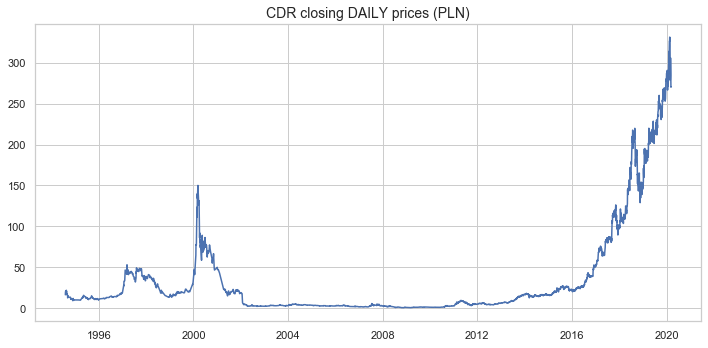

In [4]:
plt.figure(figsize=(10,5))
plt.plot(cdr["Zamknięcie"])
plt.title("CDR closing DAILY prices (PLN)", size=14)
plt.tight_layout()
plt.show()

## Descriptive statistics

### Return, volitility

In [51]:
cdr_closing_returns = cdr["Zamknięcie"].pct_change().dropna()
average_cdr_closing_returns = np.mean(cdr_closing_returns)
std_cdr_closing_returns = np.std(cdr_closing_returns)
print("Average closing return:", average_cdr_closing_returns)
print("Standard deviation of closing returns:", std_cdr_closing_returns)
print("-"*100)
print("Annualized average closing return:", (1+average_cdr_closing_returns)**252-1)
print("Annualized standard deviation of closing returns:", std_cdr_closing_returns*np.sqrt(252))

Average closing return: 0.0004575329489688095
Standard deviation of closing returns: 0.04785141655942809
----------------------------------------------------------------------------------------------------
Annualized average closing return: 0.12217855548103884
Annualized standard deviation of closing returns: 0.7596176885904283


In [56]:
log_cdr_closing_returns = (np.log(cdr["Zamknięcie"]) - np.log(cdr["Zamknięcie"]).shift(-1)).dropna()
log_average_cdr_closing_returns = np.mean(log_cdr_closing_returns)
log_std_cdr_closing_returns = np.std(log_cdr_closing_returns)

### Kurtosis, Skewness

In [52]:
print("Kurtosis:",kurtosis(log_cdr_closing_returns))
print("Skewness:", skew(log_cdr_closing_returns))

Kurtosis: 63.102709019136654
Skewness: -1.3916921515501128


In [53]:
print("Kurtosis:",kurtosis(cdr_closing_returns))
print("Skewness:", skew(cdr_closing_returns))

Kurtosis: 278.4606940718125
Skewness: 8.379693825200768


### Daily returns

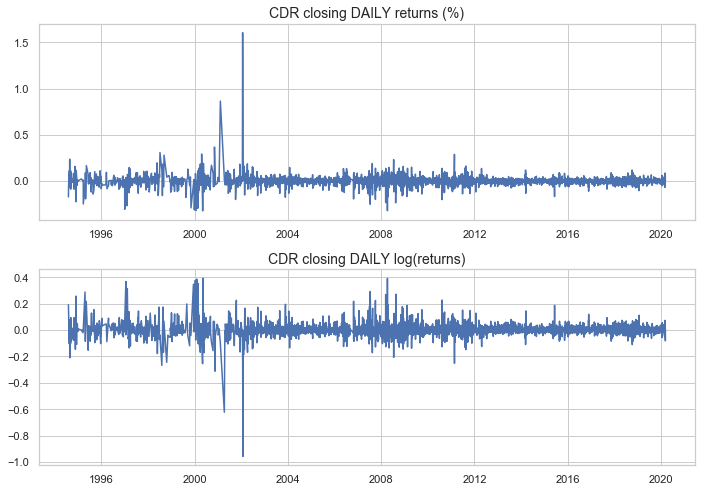

In [57]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

ax[0].plot(cdr_closing_returns)
ax[0].set_title("CDR closing DAILY returns (%)", size=14)
ax[1].plot(log_cdr_closing_returns)
ax[1].set_title("CDR closing DAILY log(returns)", size=14)

plt.tight_layout()
plt.show()

### Daily returns normality test

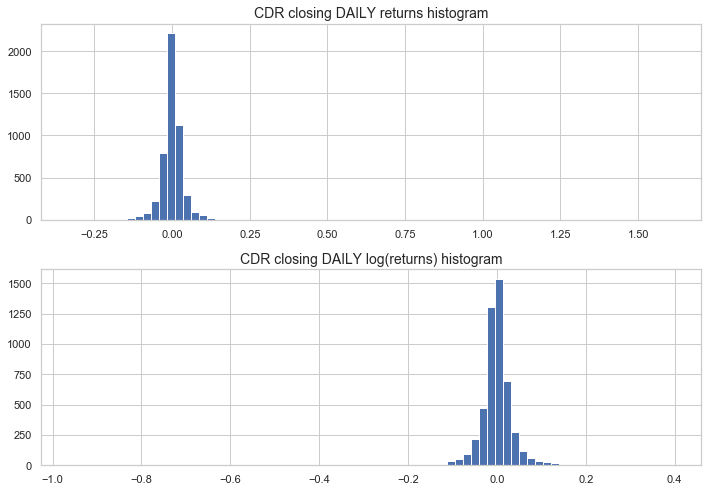

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

ax[0].hist(cdr_closing_returns, bins=75)
ax[0].set_title("CDR closing DAILY returns histogram", size=14)
ax[1].hist(log_cdr_closing_returns, bins=75)
ax[1].set_title("CDR closing DAILY log(returns) histogram", size=14)

plt.tight_layout()
plt.show()

### Shapiro-Wilk test

In [9]:
normality_test = shapiro(cdr_closing_returns)[1]

if normality_test <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


In [58]:
normality_test = shapiro(log_cdr_closing_returns)[1]

if normality_test <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


### Historical drawdown

In [10]:
cdr_closing_cumulative_returns = (1+cdr_closing_returns).cumprod()-1
running_max = np.maximum.accumulate(cdr_closing_cumulative_returns)
running_max[running_max < 1] = 1
drawdown = (cdr_closing_cumulative_returns)/running_max - 1
drawdown.max()

-0.7754347021827599

### Historical Value at Risk

In [11]:
var_level = 95
var = np.percentile(cdr_closing_returns, 100 - var_level)
print("Certaininty that daily losses will not exeed VaR% in a given day based on historical values.")
print("VaR 95%:", var)

Certaininty that daily losses will not exeed VaR% in a given day based on historical values.
VaR 95%: -0.05639981615480716


In [12]:
# var for the next 5 days
var * np.sqrt(5)

-0.12611382284063963

### Conditional historical Value at Risk

In [13]:
var_level = 95
var = np.percentile(cdr_closing_returns, 100 - var_level)
cvar = cdr_closing_returns[cdr_closing_returns < var].mean()
print("In the worst 5% of cases, losses were on average exceed % historically.")
print("CVaR 95%:", cvar)

In the worst 5% of cases, losses were on average exceed % historically.
CVaR 95%: -0.10227123180888698


### Monte Carlo simulation

In [14]:
days_ahead = 252
simulations = 2000
last_price = 270.3
results = np.empty((simulations, days_ahead))

for s in range(simulations):
    random_returns = 1 + np.random.normal(
        loc=average_cdr_closing_returns, scale=std_cdr_closing_returns, size=days_ahead)
    result = last_price * (random_returns.cumprod())
    results[s, :] = result

In [15]:
index = pd.date_range("2020-03-11", periods=days_ahead, freq="D")
results = pd.DataFrame(results.T, index=index)
results_average = results.apply("mean", axis=1)

### Monte Carlo results

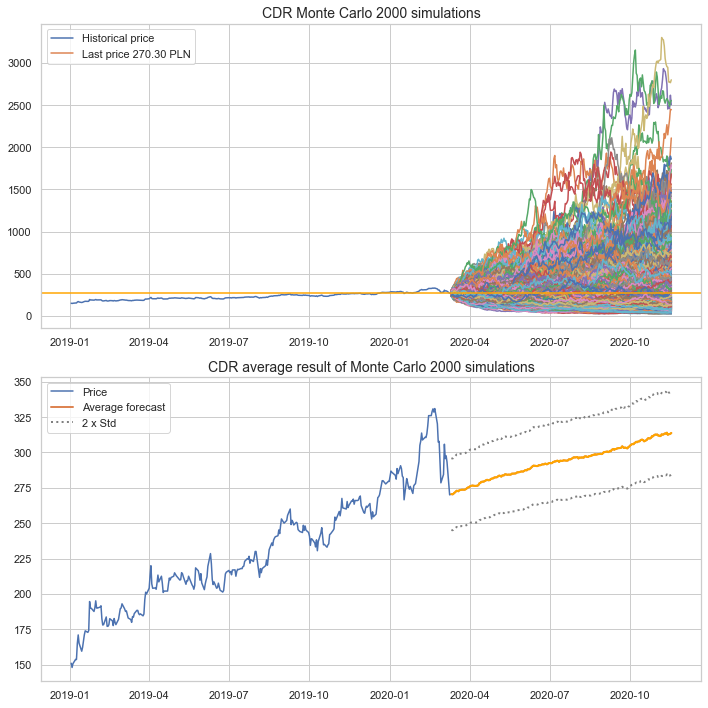

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(cdr["Zamknięcie"][:"2018-12-31"])
ax[0].plot(results)
ax[0].axhline(270.30, c="orange")
ax[0].set_title(f"CDR Monte Carlo {simulations} simulations", size=14)
ax[0].legend(["Historical price", "Last price 270.30 PLN"])

ax[1].plot(cdr["Zamknięcie"][:"2018-12-31"])
ax[1].plot(results.apply("mean", axis=1), lw=2)
ax[1].plot(results_average.apply(
    (lambda x: x * (1+1.96*std_cdr_closing_returns))), lw=2, linestyle="dotted", c="gray")
ax[1].plot(results_average, lw=2, c="orange")
ax[1].plot(results_average.apply(
    (lambda x: x * (1-1.96*std_cdr_closing_returns))), lw=2, linestyle="dotted", c="gray")
ax[1].set_title(
    f"CDR average result of Monte Carlo {simulations} simulations", size=14)
ax[1].legend(["Price", "Average forecast", "2 x Std"])

plt.tight_layout()
plt.show()